# Benchmark based on OCRBench

Here we will look specifically at the Doc-oriented VQA and the Key Information Extraction as these are the most relevant for business use cases.

In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from typing import List, Dict
import anthropic
import base64
from openai import OpenAI
import os
import PIL.Image as Image
import io
from dotenv import load_dotenv
import re
# import time sleep
from time import sleep
import json
import matplotlib.pyplot as plt
import numpy as np


# Load environment variables from .env file
load_dotenv()

# Replace the API key assignments with these lines
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
ANclient = anthropic.Anthropic(api_key=anthropic_api_key)

openai_api_key = os.getenv("OPENAI_API_KEY")
# openai_api_key = "sk-proj-"
OAIclient = OpenAI(api_key=openai_api_key)


/home/lakaschus/miniconda3/envs/NLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("echo840/OCRBench")
print(ds)

# Get all questions of the category 'Doc-oriented VQA' and 'Key Information Extraction'
doc_vqa = ds["test"].filter(lambda x: x["question_type"] == "Doc-oriented VQA")
key_info = ds["test"].filter(
    lambda x: x["question_type"] == "Key Information Extraction"
)

DatasetDict({
    test: Dataset({
        features: ['dataset', 'question', 'question_type', 'answer', 'image'],
        num_rows: 1000
    })
})


In [3]:
system_message = "You are an OCR bot for extraction information various documents. You will be provided an image and asked a question about it. Answer as truthfully as you can. If there are multiple answers or different ways of writing are possible or the answer is ambiguous, give all possible answers. Give the answer verbatim as seen in the provided text, otherwises your answer might be graded incorrectly. ALWAYS respond in this form: RESPONSE: <extracted_answer spelling 1> | <extracted_answer spelling 2> | ... . Do not add any comments of your own, only respond to the question asked."

In [ ]:
import base64
from io import BytesIO

def encode_image(image):
    # Convert image to bytes
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_byte = buffered.getvalue()
    
    # Encode to base64
    return base64.b64encode(img_byte).decode('utf-8')


def get_model_response(model: str, question: str, image) -> str:
    base64_image = encode_image(image)
    if model.startswith("gpt"):
        # OpenAI API call with image
        response = OAIclient.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": [
                        {
                            "type": "text",
                            "text": system_message
                        }
                    ]
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpg;base64,{base64_image}"}
                        },
                        {
                            "type": "text",
                            "text": question
                        },
                    ],
                }
            ],
            max_tokens=2000
        )
        return response.choices[0].message.content
    elif model.startswith("claude"):
        # Anthropic API call with image
        response = ANclient.messages.create(
            model=model,
            max_tokens=2000,
            system=system_message,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": question
                        },
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": f"{base64_image}"
                            }
                        }
                    ]
                }
            ]
        )
        return response.content[0].text

In [ ]:
def rule_based_check(label, output):
    pred, label = output.lower().strip(), label.lower().strip()
    if (pred in label) or (label in pred):
        match = True
        return match
    # Split the label into words and discount all strings that are less than 3 characters
    candidates = [p for p in pred.split() if len(p) > 2]
    pred = []
    # But keep only numbers / floats or strings that contain special characters like "1,000", "1.000", "5/7/24"
    for p in candidates:
        # print(p)
        if any([c in p for c in [",", ".", "/"]]):
            pred.append(p)
            continue
        try:
            float(p)
            pred.append(p)
        except:
            continue
    # for each number in the prediction, check if it is in the label
    # print(pred)
    if any([p in label for p in pred]):
        match = True
    else:
        match = False
    return match

In [ ]:
# Test cases for rule-based check
print(rule_based_check("1.000 Euros", "1.000"))
print(rule_based_check("1.000g", "1.000"))
print(rule_based_check("20 wks from start of fld.", "20 wks from start of fid."))
print(rule_based_check(" 820 kcal*", "820 kcal 820kcal"))

In [ ]:
def benchmark(test_set, models):
    results = {model: [] for model in models}
    for i, dat in enumerate(test_set, start=0):
        print(i)
        question = dat["question"]
        label = ' '.join([lab.lower() for lab in dat["answer"]])
        image = dat["image"]
        try:
            llm_outputs = {model: get_model_response(model, question, image) for model in models}
        except Exception as e:
            print("Error in API call")
            print(e)
            continue
        for model, llm_output in llm_outputs.items():
            print(f"Model: {model}")
            if "RESPONSE:" not in llm_output:
                print("No response")
                continue
            output = llm_output.split("RESPONSE:")[1].split("|")
            for o in output:
                if rule_based_check(label, o):
                    match = True
                    break
            else:
                match = False
            result = {
                'question': question,
                'llm_output': output,
                'label': dat["answer"],
                'match': match
            }
            results[model].append(result)
        sleep(5)
    return results

## Conduct Benchmark LLMs

In [ ]:
# List of models to benchmark
models = [
    "gpt-4-turbo",
    "gpt-4o-mini",
    "claude-3-haiku-20240307",
    "gpt-4o",
    "claude-3-5-sonnet-20240620",
]

In [ ]:
results_doc_vqa = benchmark(doc_vqa, models)

In [ ]:
# Export document-oriented VQA results to json file
with open('doc_vqa_results.json', 'w') as f:
    json.dump(results_doc_vqa, f, indent=4)

In [ ]:
results_key_info = benchmark(key_info, models)

In [ ]:
# Export document-oriented VQA results to json file
import json
with open('key_info_results.json', 'w') as f:
    json.dump(results_key_info, f, indent=4)

## Plot results

In [ ]:
def plot_results(path):
    # Load the JSON data
    with open(path, 'r') as f:
        data = json.load(f)

    # Extract recall values for each model
    model_recalls = {}
    for model, result in data.items():
        print(model)
        vals = [example['match'] for example in result]
        true_positives = sum(vals)
        total = len(vals)
        model_recalls[model] = true_positives / total

    # Prepare data for plotting
    models = list(model_recalls.keys())
    recalls = list(model_recalls.values())

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(models, recalls)
    plt.title('Average Recall by Model')
    plt.xlabel('Model')
    plt.ylabel('Average Recall')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for recall values
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

    # Add value labels on top of each bar
    for i, v in enumerate(recalls):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_results('doc_vqa_results.json')

In [ ]:
plot_results('key_info_results.json')

## Curation / Manual Validation

In [ ]:
doc_vqa
# Find the entry with the question question
question = "what year has the lowest percentage?"
entry = doc_vqa.filter(lambda x: x["question"] == question)
entry['image'][0]

Filter: 100%|██████████| 200/200 [00:01<00:00, 124.64 examples/s]


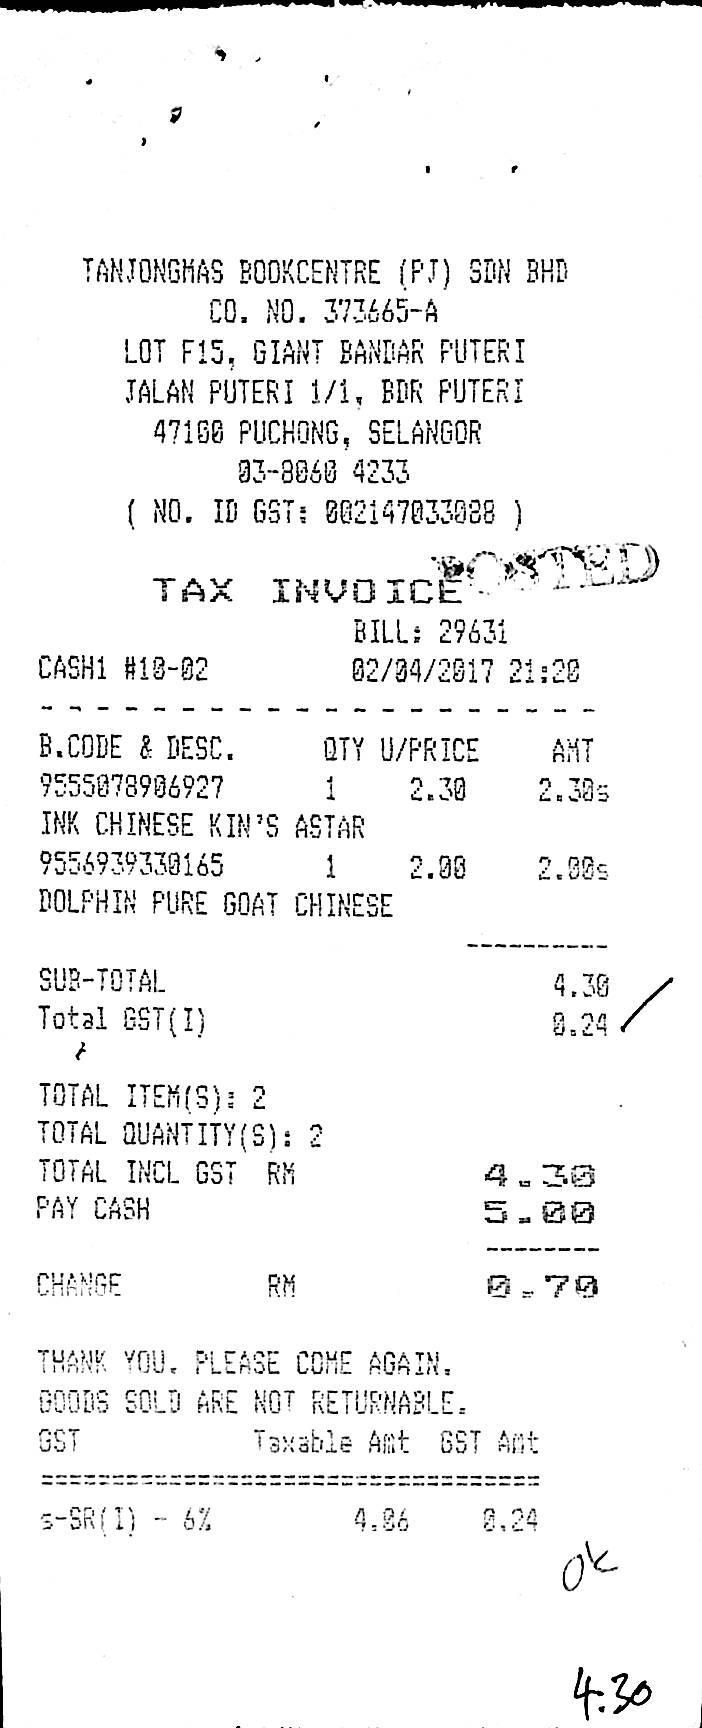

In [7]:
key_info
# Find the entry with the question question
label = "4.30"
entry = key_info.filter(lambda x: x["answer"][0] == label)
entry['image'][0]